# Importing Modules and Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Import Pandas and Numpy for accesing the dataset
import numpy as np
import pandas as pd

# Import Visualization libraries for Drawing Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import Statistics libraries for Calculations
from scipy import stats
from scipy.stats import norm

# Import Scikit-learn for Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

# Import country code libraries
!pip install pycountry -q
import pycountry

#Install plot library
import plotly.io as pio
pio.renderers.default='notebook'


# Data Pre-Processing

data = pd.read_csv('/content/ds_salaries.csv')

data.head()

In [ ]:
data = pd.read_csv('/content/sample_data/ds_salaries.csv')

data.head()

In [ ]:
import os
file_path = '/content/sample_data/ds_salaries.csv'
if os.path.exists(file_path):
        print(f"The file {file_path} exists.")
else:
        print(f"The file {file_path} does not exist.")

The file /content/sample_data/ds_salaries.csv exists.


# Calculate the ratio of missing values for each column

df = pd.DataFrame(data)

missing_ratio = df.isnull().sum() / len(df)

print("Ratio of missing values in each column:")
print(missing_ratio)

In [ ]:
df = pd.DataFrame(data)

missing_ratio = df.isnull().sum() / len(df)

print("Ratio of missing values in each column:")
print(missing_ratio)

Ratio of missing values in each column:
work_year             0.0
experience_level      0.0
employment_type       0.0
job_title             0.0
salary                0.0
salary_currency       0.0
salary_in_usd         0.0
employee_residence    0.0
remote_ratio          0.0
company_location      0.0
company_size          0.0
dtype: float64


In [ ]:
df = pd.DataFrame(data)

# Count duplicate rows
duplicate_rows_count = df.duplicated().sum()

# Count duplicate columns
duplicate_columns_count = df.T.duplicated().sum()

print(f"Number of duplicate rows: {duplicate_rows_count}")
print(f"Number of duplicate columns: {duplicate_columns_count}")

Number of duplicate rows: 1171
Number of duplicate columns: 0


# Count distinct variables in each column
distinct_counts = df.nunique()

# Display the result
print("Number of distinct values in each column:")
print(distinct_counts)

# Renaming for Better Mining

In [ ]:
data['experience_level'] = data['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid/Intermediate level'})

In [ ]:
data['employment_type'] = data['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})

In [ ]:
data['company_size'] = data['company_size'].replace({
    'S': 'SMALL',
    'M': 'MEDIUM',
    'L' : 'LARGE',
})

In [ ]:
#Since Remote Ratio determine whether the employee is working on site, hybrid or work at home, we classify them into these 3 catogries instead of 0.50.100
data['remote_ratio'] = data['remote_ratio'].astype(str)
data['remote_ratio'] = data['remote_ratio'].replace({
    '0': 'On-Site',
    '50': 'Half-Remote',
    '100' : 'Full-Remote',
})

### Updates Dataset after Renaming

In [ ]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,Senior,Full-time,Principal Data Scientist,80000,EUR,85847,ES,Full-Remote,ES,LARGE
1,2023,Mid/Intermediate level,Contractor,ML Engineer,30000,USD,30000,US,Full-Remote,US,SMALL
2,2023,Mid/Intermediate level,Contractor,ML Engineer,25500,USD,25500,US,Full-Remote,US,SMALL
3,2023,Senior,Full-time,Data Scientist,175000,USD,175000,CA,Full-Remote,CA,MEDIUM
4,2023,Senior,Full-time,Data Scientist,120000,USD,120000,CA,Full-Remote,CA,MEDIUM


# Function To Classify Jobs into Categories

In [ ]:
def job_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]

    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

data['job_category'] = data['job_title'].apply(job_category)

# Dealing With Inflation and using a base Currency

In [ ]:
import pandas as pd

# Updated Indian inflation rates (replace with actual data)
indian_inflation_rates = {
    2019: 0.036,  # 3.6% inflation in 2019
    2020: 0.062,  # 6.2% inflation in 2020
    2021: 0.050,  # 5.0% inflation in 2021
    2022: 0.057,  # 5.7% inflation in 2022
    2023: 0.062   # 6.2% inflation in 2023
}

# Global inflation rates (hypothetical data for currencies other than USD)
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

# Currency conversion rates (for USD and EUR to INR)
conversion_rates = {'USD': 83.0, 'EUR': 91.0}

# Function to adjust salary with respect to INR and convert to lakhs
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']  # assuming salary is initially in USD
    salary_currency = row['salary_currency']


    if year == 2023:
        adjusted_salary = original_salary
    else:
        adjusted_salary = original_salary

        for y in range(year, 2023):
            inflation_rate = indian_inflation_rates.get(y, 0)
            adjusted_salary *= (1 + inflation_rate)

    # Convert to INR based on the currency
    if salary_currency == 'USD':
        converted_salary = adjusted_salary * conversion_rates.get('USD', 1.0)
    elif salary_currency == 'EUR':
        converted_salary = adjusted_salary * conversion_rates.get('EUR', 1.0)
    else:
        converted_salary = adjusted_salary

    # Convert salary to lakhs (1 lakh = 100,000 INR)
    salary_in_lakhs = converted_salary / 100000
    return salary_in_lakhs


data['salary_in_lakhs'] = data.apply(adjust_salary, axis=1)

# Display the first few rows of the modified DataFrame
print(data[['work_year', 'salary_in_lakhs']].head())

   work_year  salary_in_lakhs
0       2023         78.12077
1       2023         24.90000
2       2023         21.16500
3       2023        145.25000
4       2023         99.60000


In [ ]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,salary_in_lakhs
0,2023,Senior,Full-time,Principal Data Scientist,80000,EUR,85847,ES,Full-Remote,ES,LARGE,Other,78.12077
1,2023,Mid/Intermediate level,Contractor,ML Engineer,30000,USD,30000,US,Full-Remote,US,SMALL,Machine Learning,24.90000
2,2023,Mid/Intermediate level,Contractor,ML Engineer,25500,USD,25500,US,Full-Remote,US,SMALL,Machine Learning,21.16500
3,2023,Senior,Full-time,Data Scientist,175000,USD,175000,CA,Full-Remote,CA,MEDIUM,Data Science,145.25000
4,2023,Senior,Full-time,Data Scientist,120000,USD,120000,CA,Full-Remote,CA,MEDIUM,Data Science,99.60000


# Descriptive Analysis

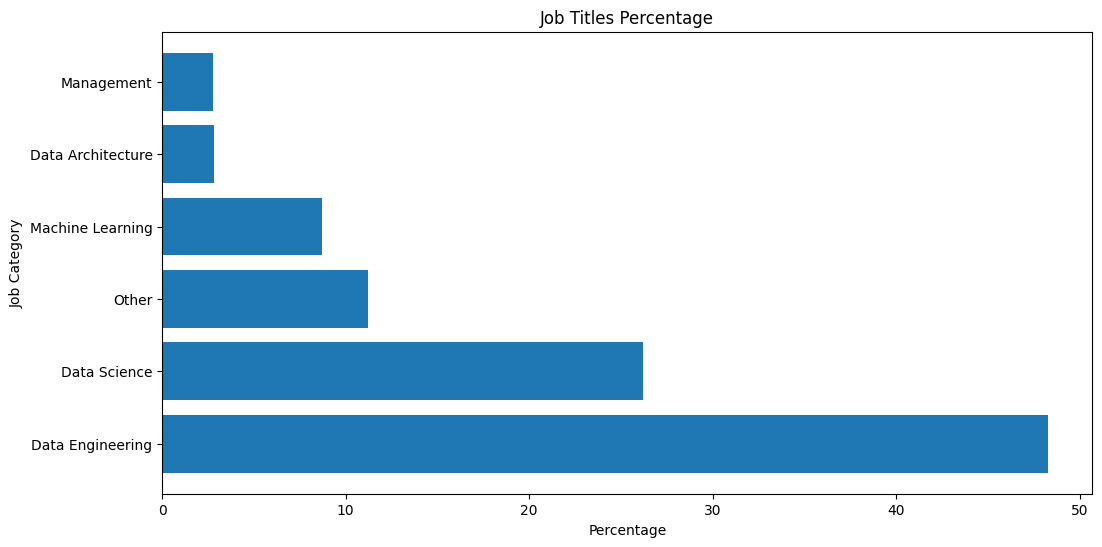

In [ ]:
value_counts = data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

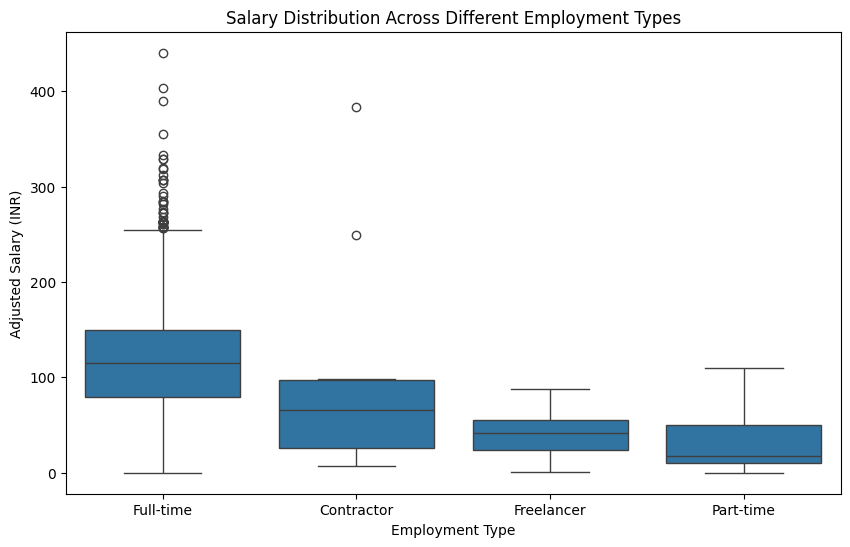

In [ ]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='employment_type', y='salary_in_lakhs')
plt.title('Salary Distribution Across Different Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Adjusted Salary (INR)')
plt.show()

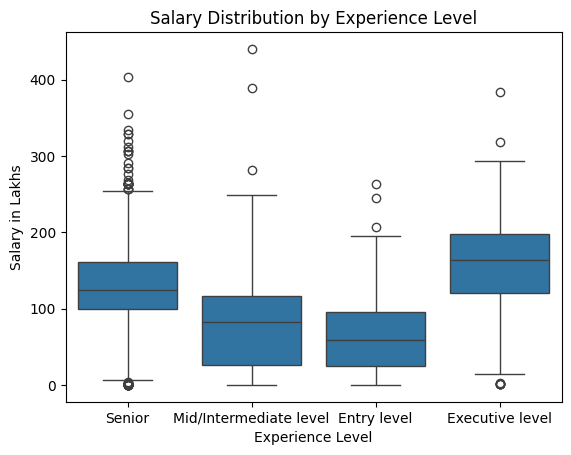

In [ ]:
sns.boxplot(data=data, x='experience_level', y='salary_in_lakhs')
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary in Lakhs')
plt.show()

salary_in_lakhs: mu = 113.45, sigma = 59.22
salary_in_lakhs: Skewness: 0.18
salary_in_lakhs: Kurtosis: 0.65


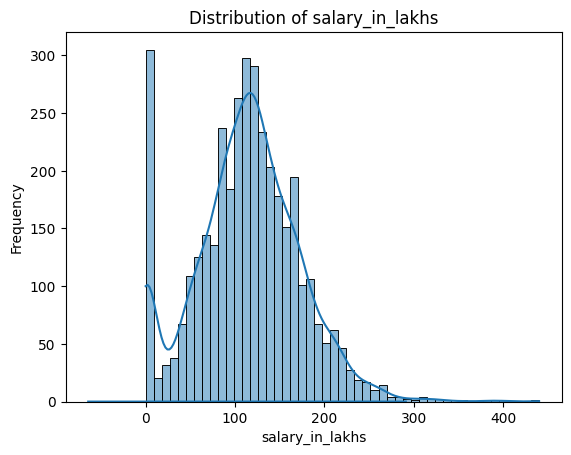

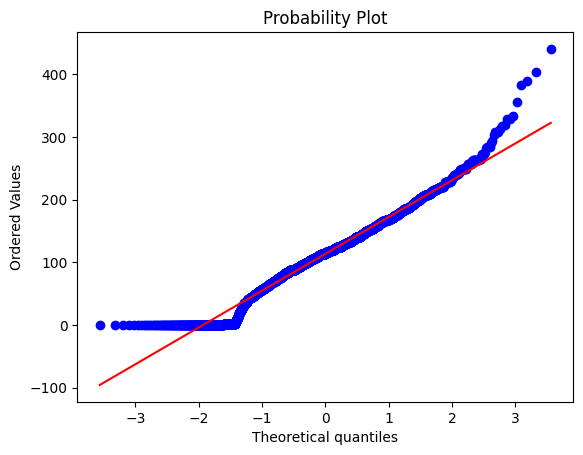

In [ ]:
columns = ['salary_in_lakhs']


for col in columns:

    sns.histplot(data[col], kde=True)

    (mu, sigma) = stats.norm.fit(data[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

    print('{}: Skewness: {:.2f}'.format(col, data[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, data[col].kurt()))

    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')

    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))

    fig = plt.figure()
    stats.probplot(data[col], plot=plt)

    plt.show()

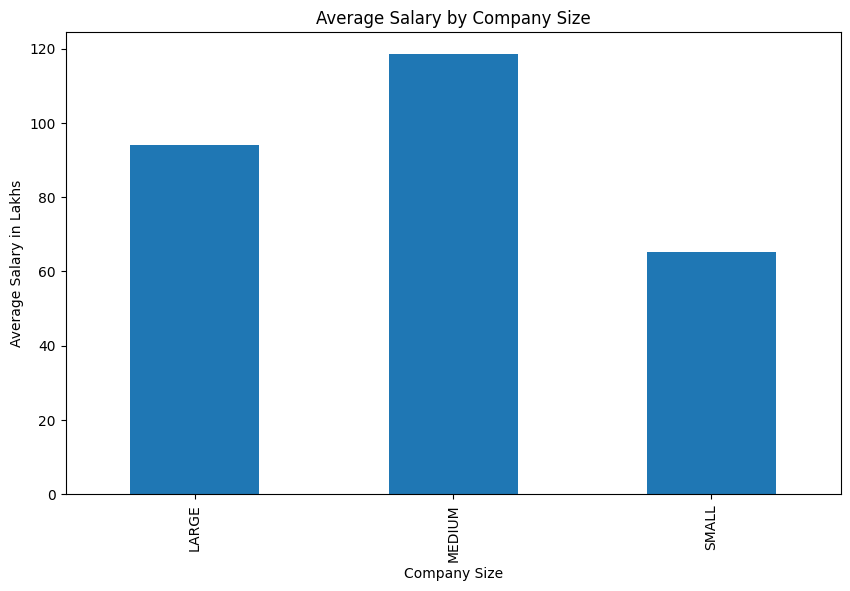

In [ ]:
plt.figure(figsize=(10, 6))
avg_salary_by_size = data.groupby('company_size')['salary_in_lakhs'].mean()
avg_salary_by_size.plot(kind='bar')
plt.title('Average Salary by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Average Salary in Lakhs')
plt.show()

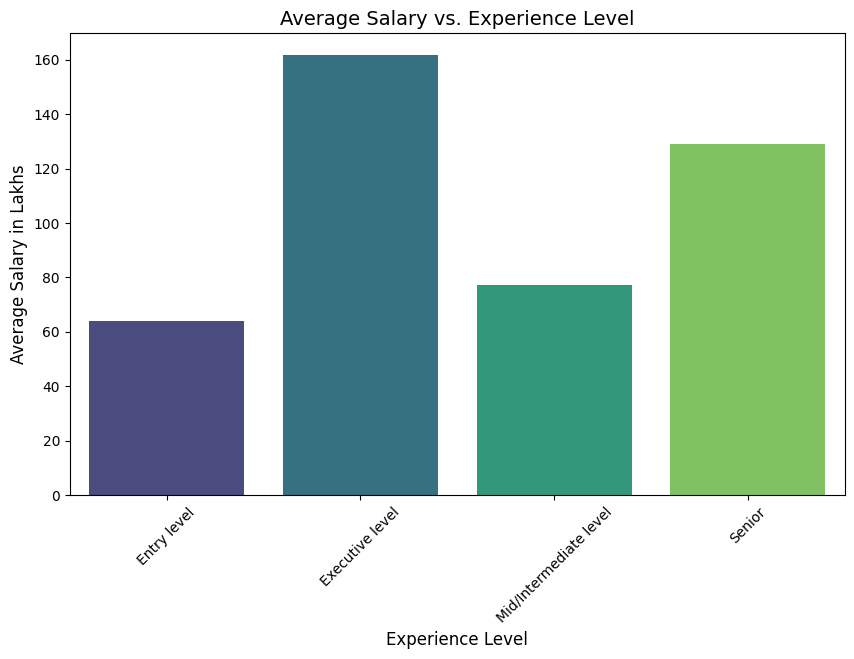

In [ ]:
avg_salary = data.groupby('experience_level')['salary_in_lakhs'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_salary, x='experience_level', y='salary_in_lakhs', palette='viridis')
plt.title('Average Salary vs. Experience Level', fontsize=14)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Average Salary in Lakhs', fontsize=12)
plt.xticks(rotation=45)
plt.show()

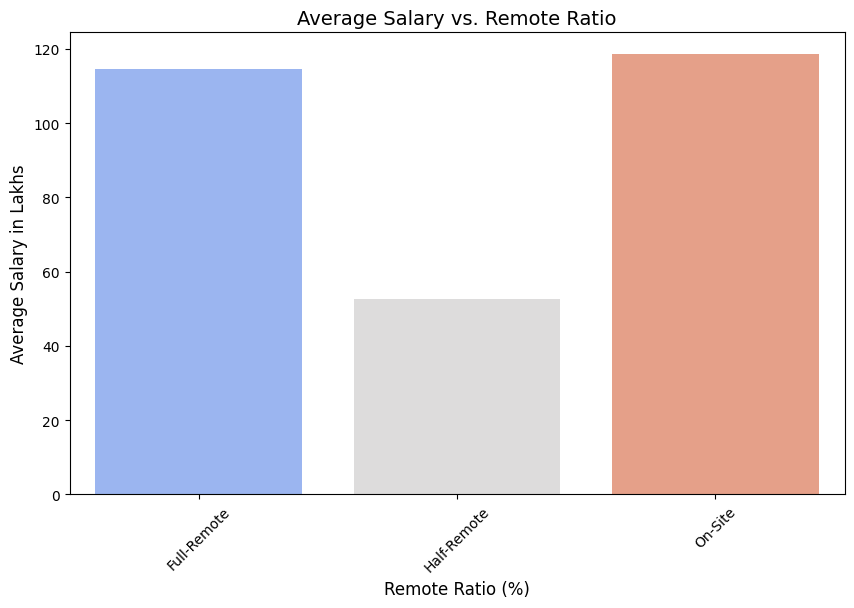

In [ ]:
avg_salary_remote = data.groupby('remote_ratio')['salary_in_lakhs'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_salary_remote, x='remote_ratio', y='salary_in_lakhs', palette='coolwarm')
plt.title('Average Salary vs. Remote Ratio', fontsize=14)
plt.xlabel('Remote Ratio (%)', fontsize=12)
plt.ylabel('Average Salary in Lakhs', fontsize=12)
plt.xticks(rotation=45)
plt.show()

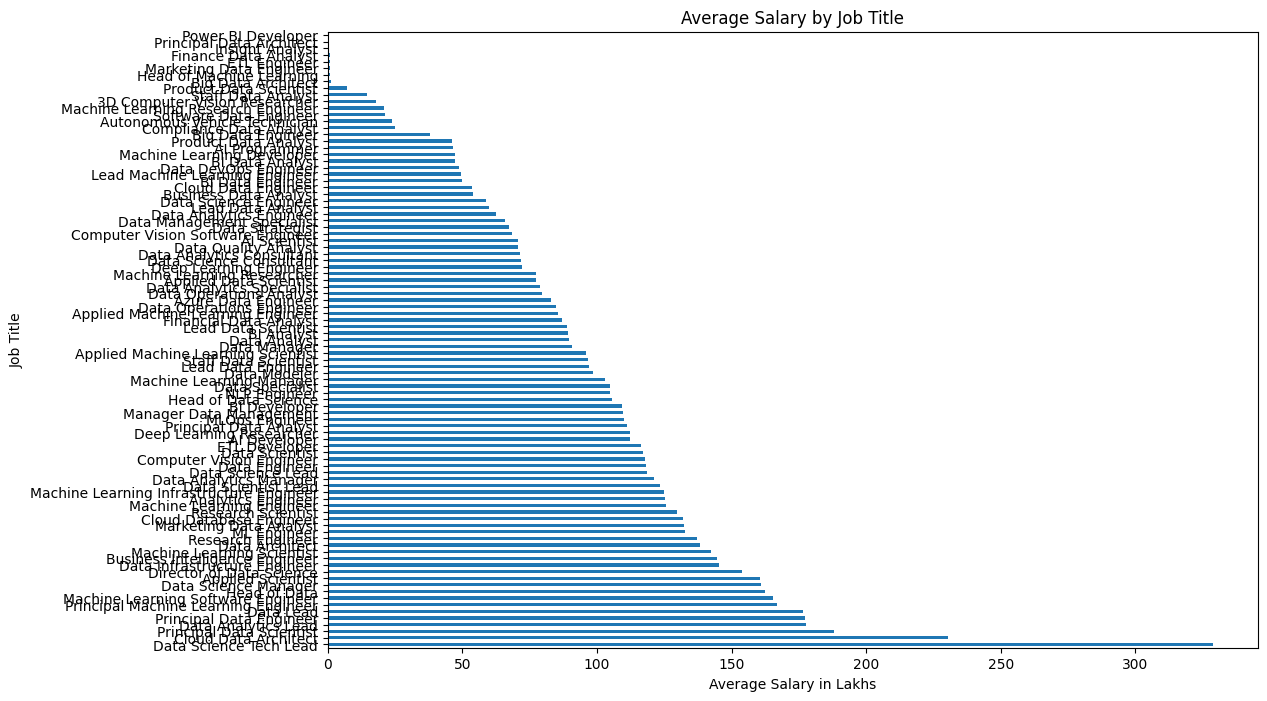

In [ ]:
plt.figure(figsize=(12, 8))
avg_salary_by_title = data.groupby('job_title')['salary_in_lakhs'].mean().sort_values(ascending=False)
avg_salary_by_title.plot(kind='barh')
plt.title('Average Salary by Job Title')
plt.xlabel('Average Salary in Lakhs')
plt.ylabel('Job Title')
plt.show()

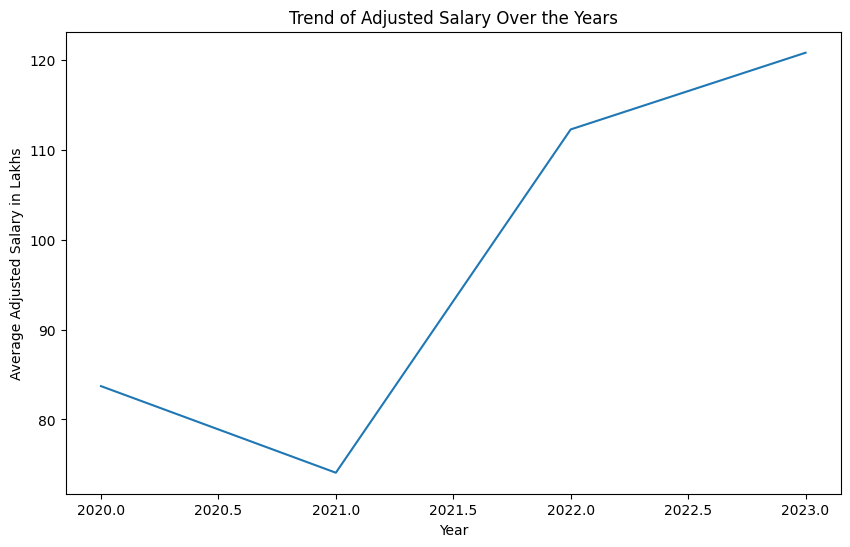

In [ ]:
plt.figure(figsize=(10, 6))
avg_adjusted_salary_by_year = data.groupby('work_year')['salary_in_lakhs'].mean()
avg_adjusted_salary_by_year.plot(kind='line')
plt.title('Trend of Adjusted Salary Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Adjusted Salary in Lakhs')
plt.show()

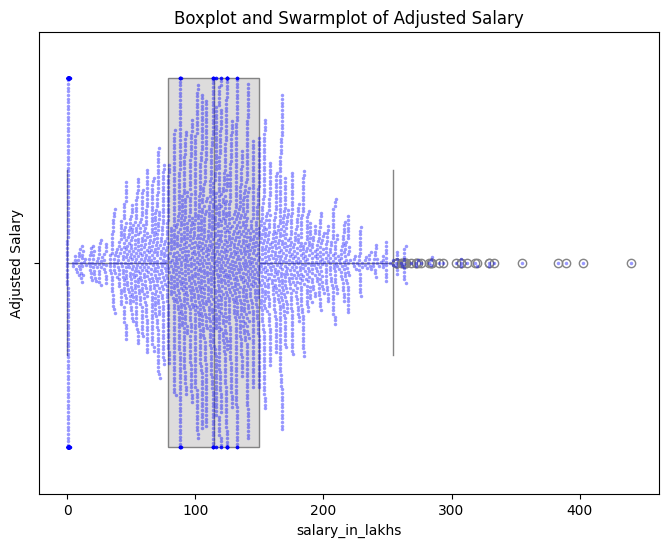

,salary_in_lakhs
count,3755.00
mean,113.45
std,59.23
min,0.05
25%,78.85
50%,114.49
75%,149.40
max,440.23


In [ ]:
formatted_data = data.loc[:, 'salary_in_lakhs'].describe().apply(lambda x: f'{x:.2f}')

plt.figure(figsize=(8, 6))
sns.boxplot(x=data['salary_in_lakhs'], palette='coolwarm')
sns.swarmplot(x=data['salary_in_lakhs'], color='blue', alpha=0.4, size=2.5)
plt.ylabel('Adjusted Salary')
plt.title('Boxplot and Swarmplot of Adjusted Salary')
plt.show()

styled_data = formatted_data.to_frame().style \
    .background_gradient(cmap='Blues') \
    .set_properties(**{'text-align': 'center', 'border': '1px solid black'})

display(styled_data)

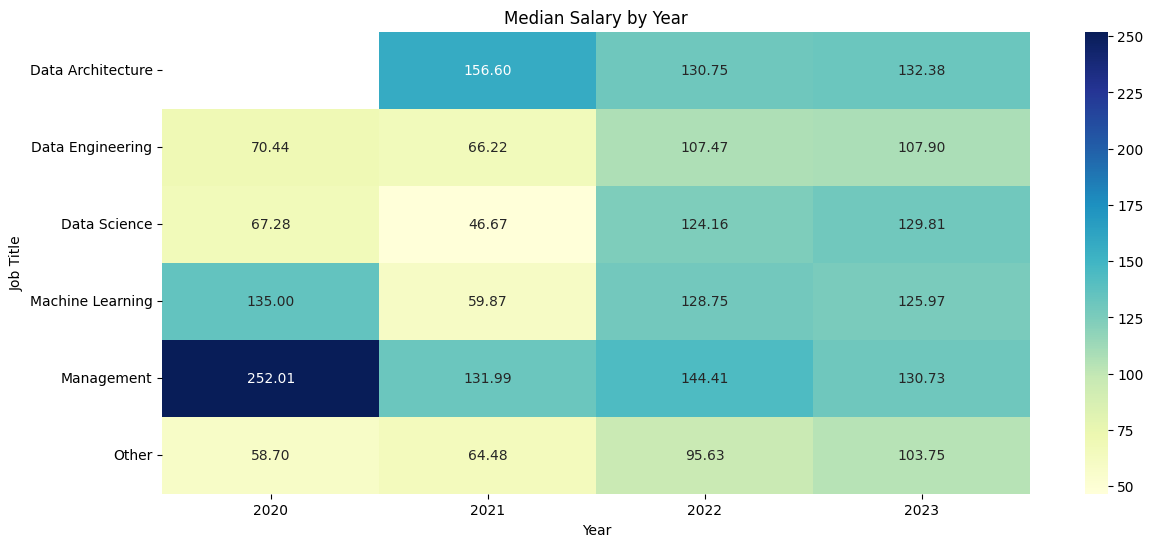

In [ ]:
df = data.copy()

pivot_table = df.pivot_table(values='salary_in_lakhs', index='job_category', columns='work_year', aggfunc='median')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Median Salary by Year')
plt.xlabel('Year')
plt.ylabel('Job Title')
plt.show()

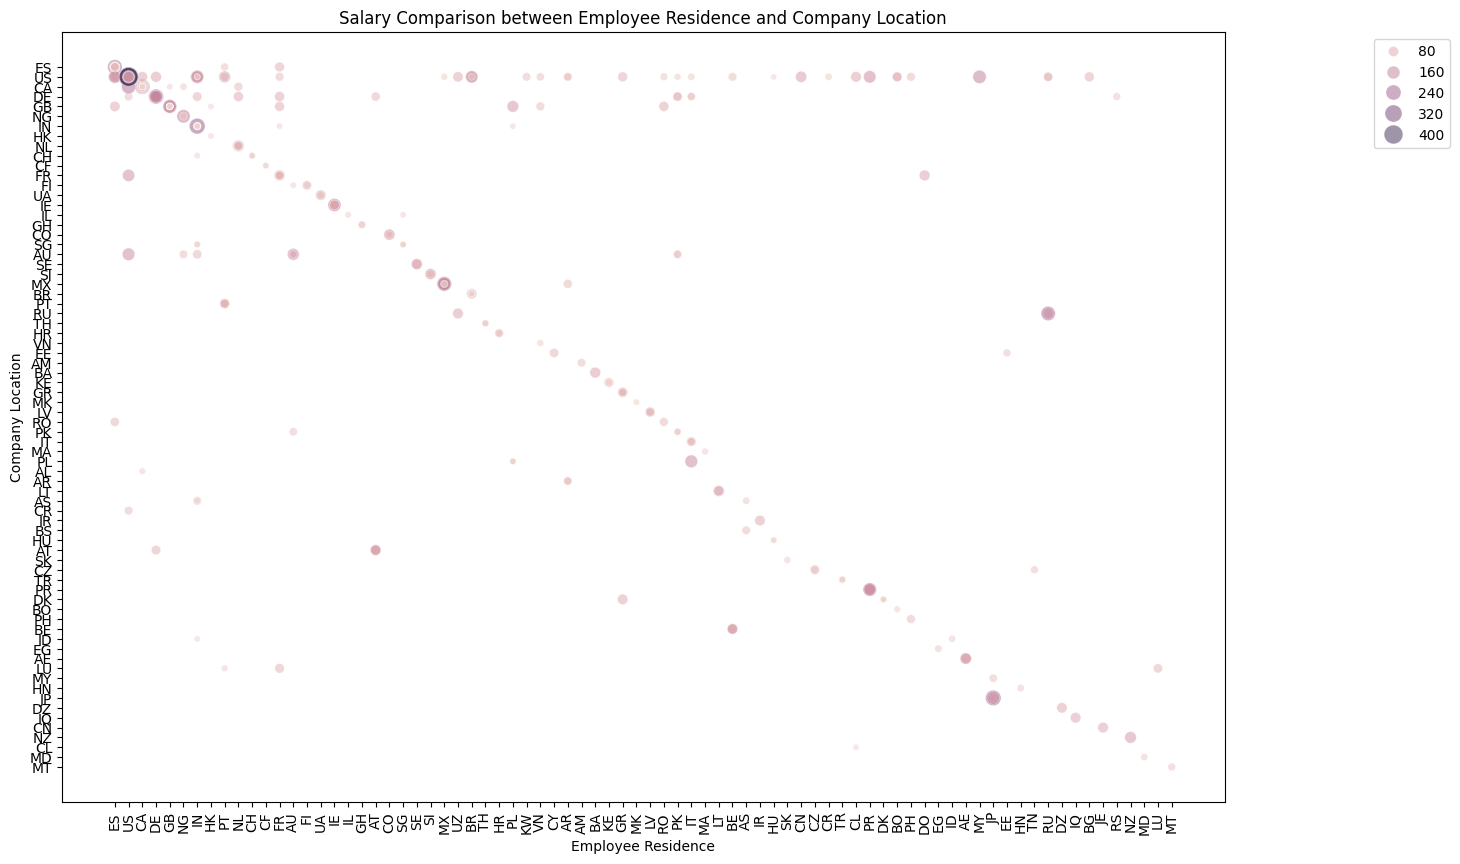

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x='employee_residence', y='company_location', hue='salary_in_lakhs', size='salary_in_lakhs', sizes=(20, 200), alpha=0.5)
plt.title('Salary Comparison between Employee Residence and Company Location')
plt.xlabel('Employee Residence')
plt.ylabel('Company Location')
plt.xticks(rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

In [ ]:
# Function to convert ISO 3166 country code to country name
def country_code_to_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return country_code

def country_code_to_name(code):
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.name
    except:
        return None

# World Map Plot

In [ ]:
!pip install plotly pandas seaborn

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
pip install pandas plotly seaborn matplotlib pycountry

In [ ]:
%matplotlib inline

In [ ]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,salary_in_lakhs
0,2023,Senior,Full-time,Principal Data Scientist,80000,EUR,85847,ES,Full-Remote,ES,LARGE,Other,78.12077
1,2023,Mid/Intermediate level,Contractor,ML Engineer,30000,USD,30000,US,Full-Remote,US,SMALL,Machine Learning,24.90000
2,2023,Mid/Intermediate level,Contractor,ML Engineer,25500,USD,25500,US,Full-Remote,US,SMALL,Machine Learning,21.16500
3,2023,Senior,Full-time,Data Scientist,175000,USD,175000,CA,Full-Remote,CA,MEDIUM,Data Science,145.25000
4,2023,Senior,Full-time,Data Scientist,120000,USD,120000,CA,Full-Remote,CA,MEDIUM,Data Science,99.60000


In [ ]:
!pip install pycountry

import pycountry

def country_code_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except AttributeError:
        return code

In [ ]:
import pycountry

def country_code_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except AttributeError:
        return None

In [ ]:
import pycountry

def country_code_to_name(code):
    try:

        if not isinstance(code, str):
            return None
        return pycountry.countries.get(alpha_2=code).name
    except (LookupError, AttributeError):

        return None

df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)


df = df.dropna(subset=['company_location', 'employee_residence'])

In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'

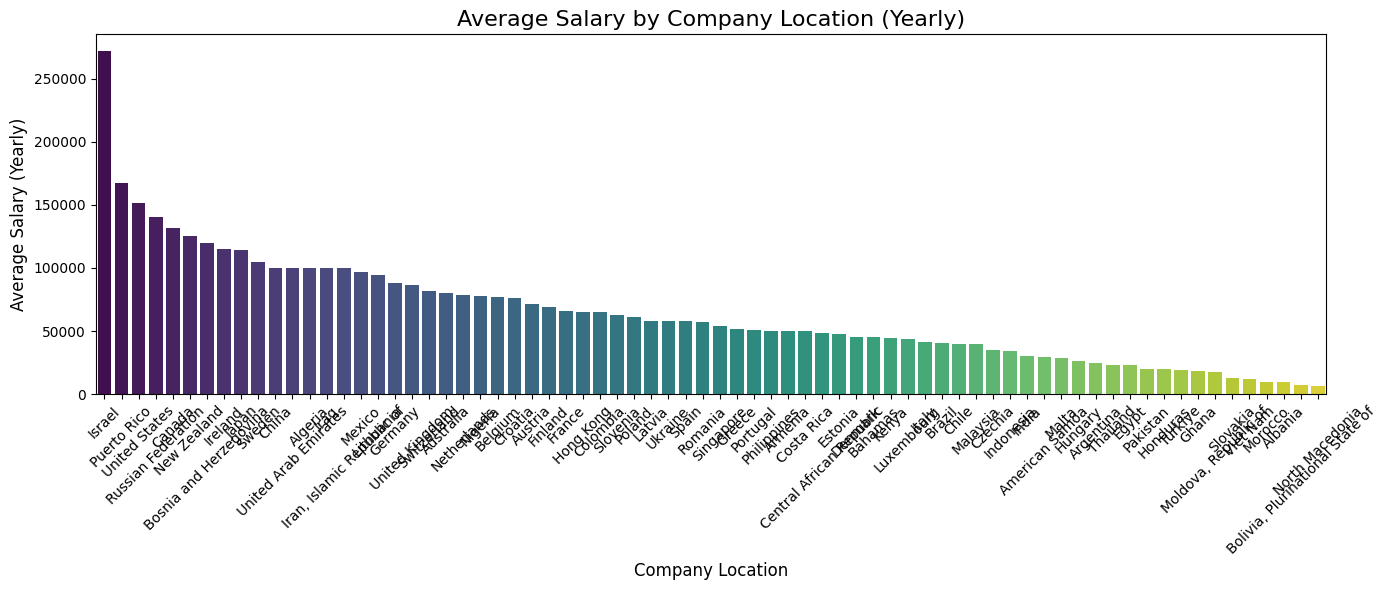

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry

# Function to convert country codes to full country names
def country_code_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except AttributeError:
        return code


df = pd.DataFrame(data)

# Convert country codes to full country names
df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

# Calculate average salary by company location
avg_salary_by_location = df.groupby('company_location', as_index=False)['salary_in_usd'].mean()

# --- Choropleth Map ---
# Generate the choropleth map
fig1 = px.choropleth(
    avg_salary_by_location,
    locations='company_location',
    locationmode='country names',
    color='salary_in_usd',
    hover_name='company_location',
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Average Salary by Company Location',
    labels={'salary_in_usd': 'Average Salary (in USD)'},
    projection='natural earth'
)

# Display the map
fig1.show()

# --- Bar Plot ---
# Sort countries by average salary
avg_salary_by_location_sorted = avg_salary_by_location.sort_values(by='salary_in_usd', ascending=False)

# Create a bar plot
plt.figure(figsize=(14, 6))
sns.barplot(
    x='company_location',
    y='salary_in_usd',
    data=avg_salary_by_location_sorted,
    palette='viridis'
)
plt.title('Average Salary by Company Location (Yearly)', fontsize=16)
plt.xlabel('Company Location', fontsize=12)
plt.ylabel('Average Salary (Yearly)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()


plt.show()

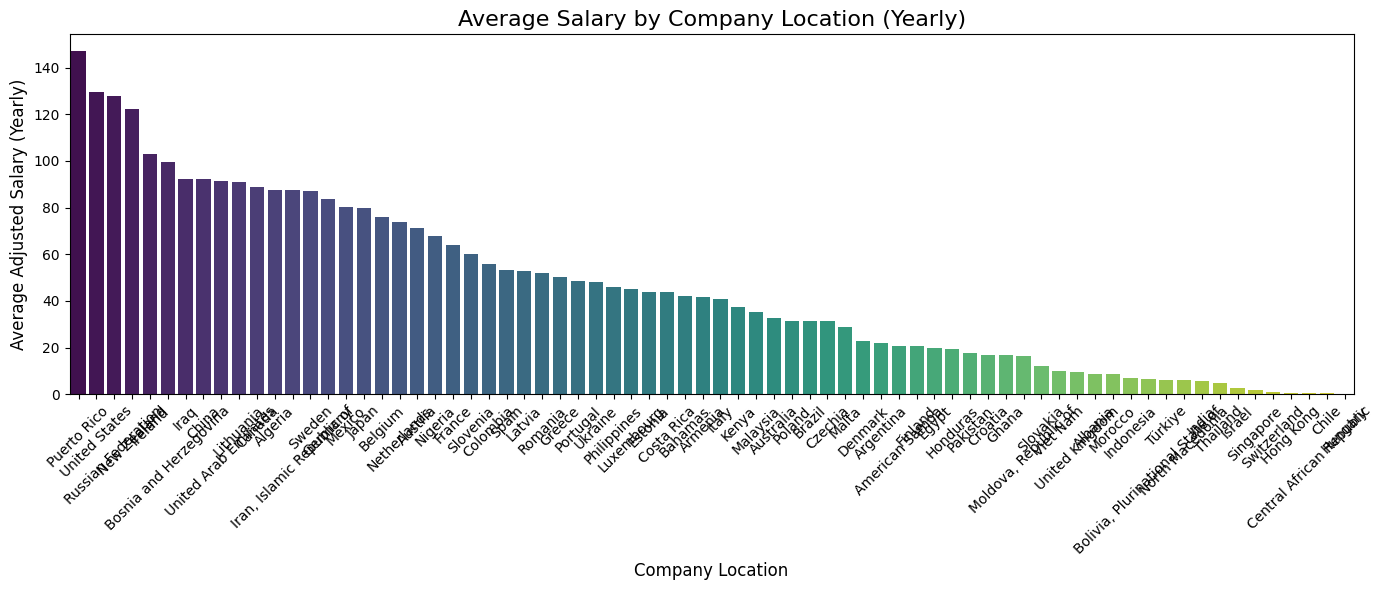

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry

def country_code_to_name(country_code):
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        return country.name if country else country_code
    except Exception as e:
        return country_code

df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

avg_salary_by_location = df.groupby('company_location', as_index=False)['salary_in_lakhs'].mean()

fig1 = px.choropleth(
    avg_salary_by_location,
    locations='company_location',
    locationmode='country names',
    color='salary_in_lakhs',
    hover_name='company_location',
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Average Salary by Company Location',
    labels={'salary_in_lakhs': 'Average Adjusted Salary (in Lakhs)'}
)

fig1.show()

avg_salary_by_location_sorted = avg_salary_by_location.sort_values(by='salary_in_lakhs', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(
    x='company_location',
    y='salary_in_lakhs',
    data=avg_salary_by_location_sorted,
    palette='viridis'
)
plt.title('Average Salary by Company Location (Yearly)', fontsize=16)
plt.xlabel('Company Location', fontsize=12)
plt.ylabel('Average Adjusted Salary (Yearly)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


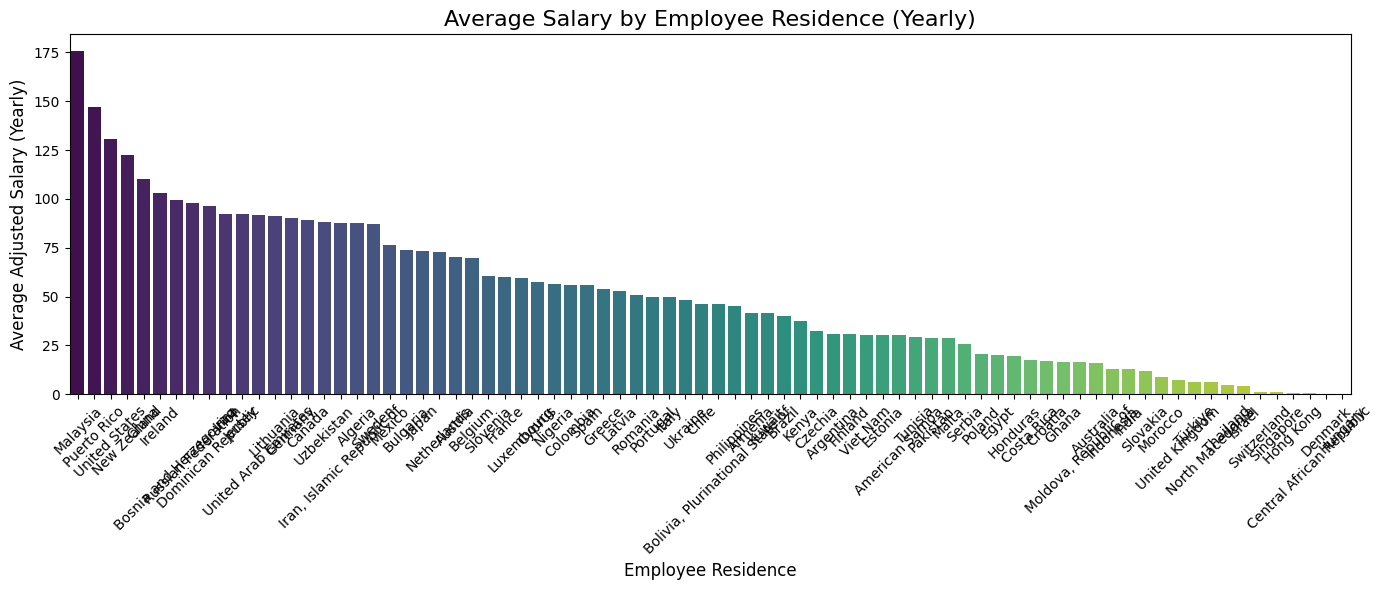

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry

def country_code_to_name(country_code):
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        return country.name if country else country_code
    except Exception as e:
        return country_code

df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

avg_salary_by_residence = df.groupby('employee_residence', as_index=False)['salary_in_lakhs'].mean()

fig2 = px.choropleth(
    avg_salary_by_residence,
    locations='employee_residence',
    locationmode='country names',
    color='salary_in_lakhs',
    hover_name='employee_residence',
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Average Salary by Employee Residence',
    labels={'salary_in_lakhs': 'Average Adjusted Salary (in Lakhs)'}
)

fig2.show()

avg_salary_by_residence_sorted = avg_salary_by_residence.sort_values(by='salary_in_lakhs', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(
    x='employee_residence',
    y='salary_in_lakhs',
    data=avg_salary_by_residence_sorted,
    palette='viridis'
)
plt.title('Average Salary by Employee Residence (Yearly)', fontsize=16)
plt.xlabel('Employee Residence', fontsize=12)
plt.ylabel('Average Adjusted Salary (Yearly)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import pycountry

# Function to convert ISO 3166 country code to country name
def country_code_to_name(country_code):
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        return country.name if country else country_code
    except Exception as e:
        return country_code

# Filter for remote_ratio of 'Full-Remote'
remote_100 = data[data['remote_ratio'] == 'Full-Remote']

# Aggregate by country code
country_counts = remote_100['company_location'].value_counts().reset_index()
country_counts.columns = ['country_code', 'count']

# Convert country codes to full names
country_counts['country_name'] = country_counts['country_code'].apply(country_code_to_name)

# Create the choropleth map with a logarithmic color scale
fig = px.choropleth(country_counts,
                    locations='country_name',
                    locationmode='country names',
                    color=np.log10(country_counts['count']),
                    hover_name='country_name',
                    hover_data=['count'],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Choropleth Map of Full-Remote Company Locations',
                    projection='natural earth')

fig.update_coloraxes(colorbar=dict(title='Count (Log Scale)', tickvals=[0, 1, 2, 3], ticktext=['1', '10', '100', '1000']))

fig.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import pycountry

# Function to convert ISO 3166 country code to country name
def country_code_to_name(country_code):
    try:
        country = pycountry.countries.get(alpha_2=country_code)
        return country.name if country else country_code
    except Exception as e:
        return country_code

# Filter for remote_ratio of 'On-Site'
remote_0 = data[data['remote_ratio'] == 'On-Site']

# Aggregate by country code
country_counts = remote_0['company_location'].value_counts().reset_index()
country_counts.columns = ['country_code', 'count']

# Convert country codes to full names
country_counts['country_name'] = country_counts['country_code'].apply(country_code_to_name)

# Create the choropleth map with a logarithmic color scale
fig = px.choropleth(country_counts,
                    locations='country_name',
                    locationmode='country names',
                    color=np.log10(country_counts['count']),
                    hover_name='country_name',
                    hover_data=['count'],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Choropleth Map of On-Site Company Locations',
                    projection='natural earth')


fig.update_coloraxes(colorbar=dict(title='Count (company)', tickvals=[0, 1, 2, 3], ticktext=['1', '10', '100', '1000']))

fig.show()

# Finding the Relations and Patterns

In [ ]:
import pandas as pd

# Inflation rates
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}

# Function to adjust salary
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates.get(y, 0)
        else:
            inflation_rate = global_inflation_rates.get(y, 0)

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary

# Function to process the dataset
def process_file(input_path, output_path):
    data = pd.read_csv(input_path)

    data['adjusted_salary'] = data.apply(adjust_salary, axis=1)

    data.to_csv(output_path, index=False)
    print(f"Modified dataset saved to {output_path}")


input_file_path = "/content/sample_data/ds_salaries.csv"
output_file_path = "ml_dataset.csv"

process_file(input_file_path, output_file_path)

Modified dataset saved to ml_dataset.csv


In [ ]:
data = pd.read_csv('/content/ml_dataset.csv')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,adjusted_salary
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,85847.0
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,30000.0
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,25500.0
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,175000.0
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,120000.0


Dataset loaded successfully!


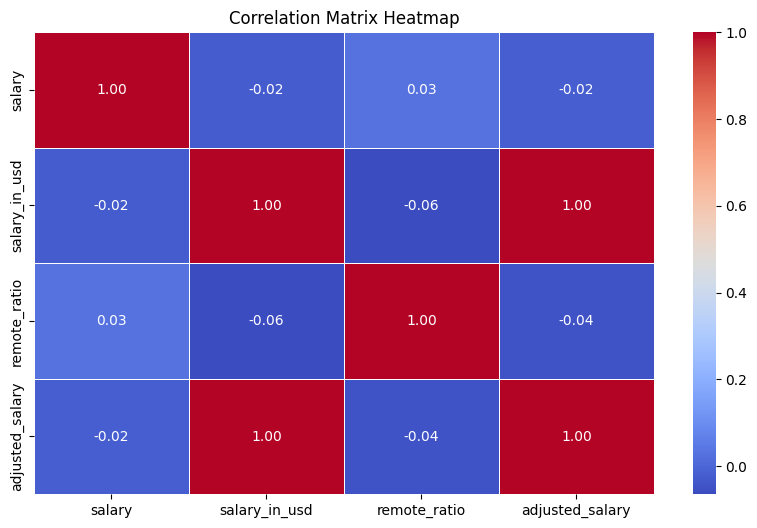

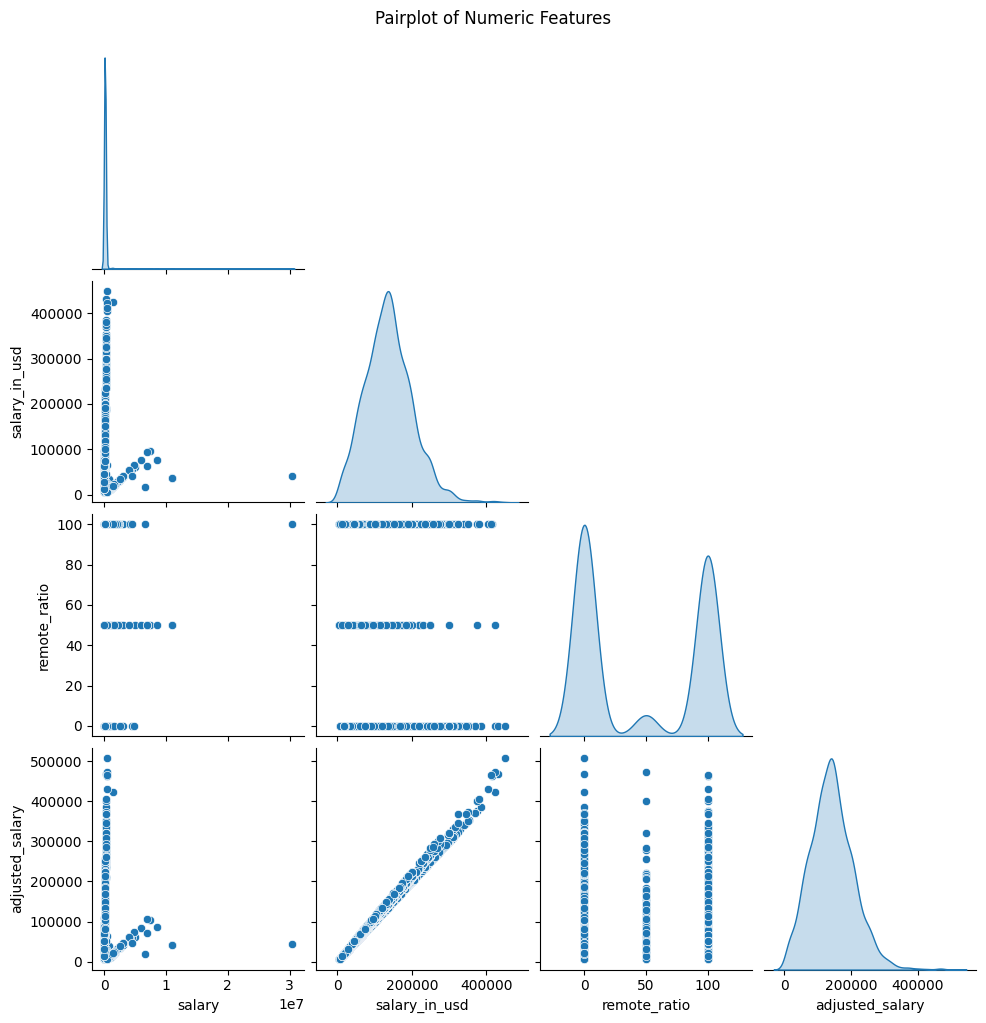

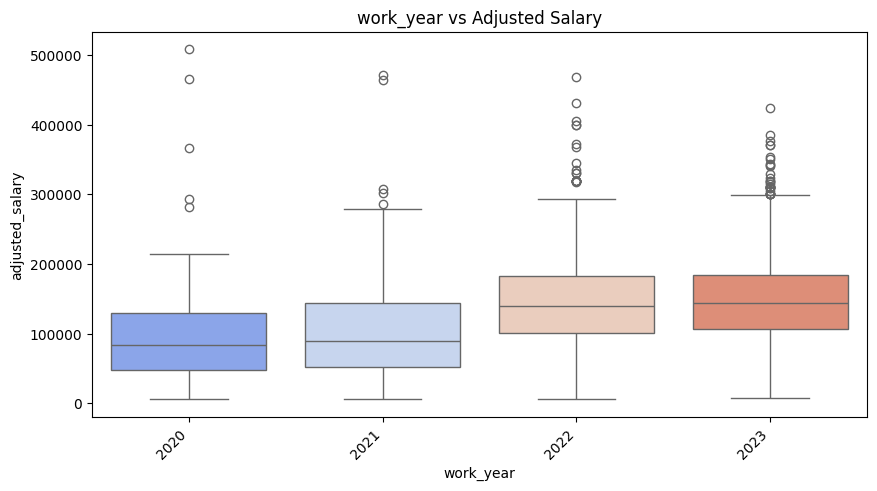

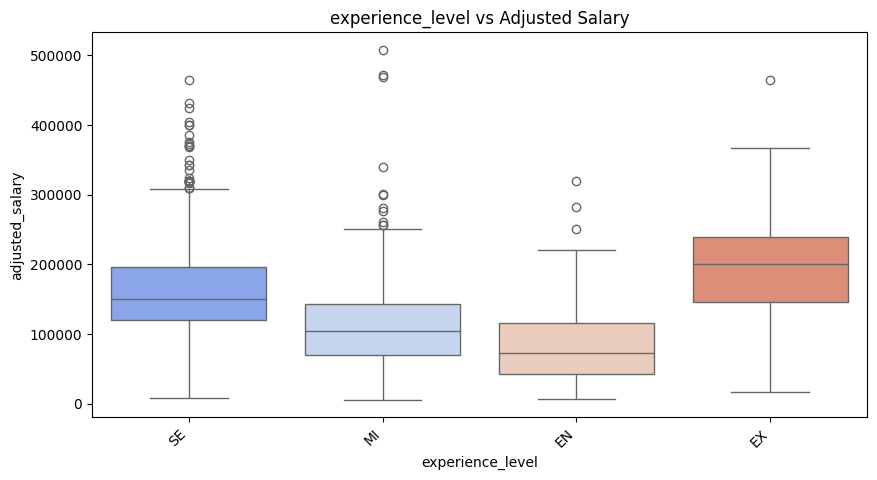

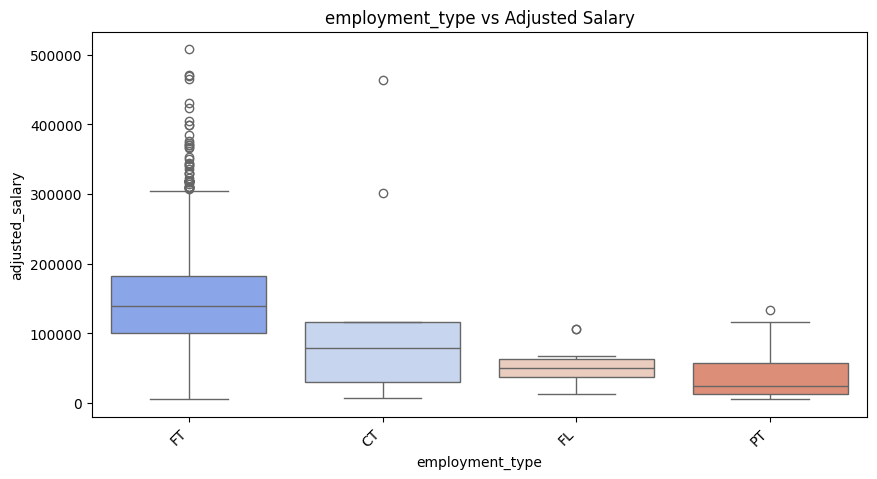

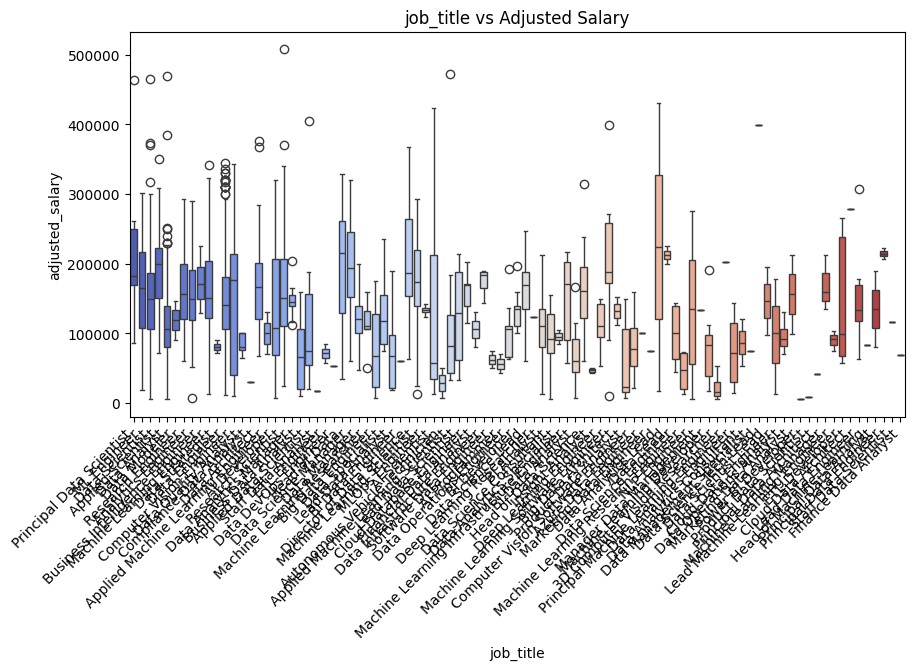

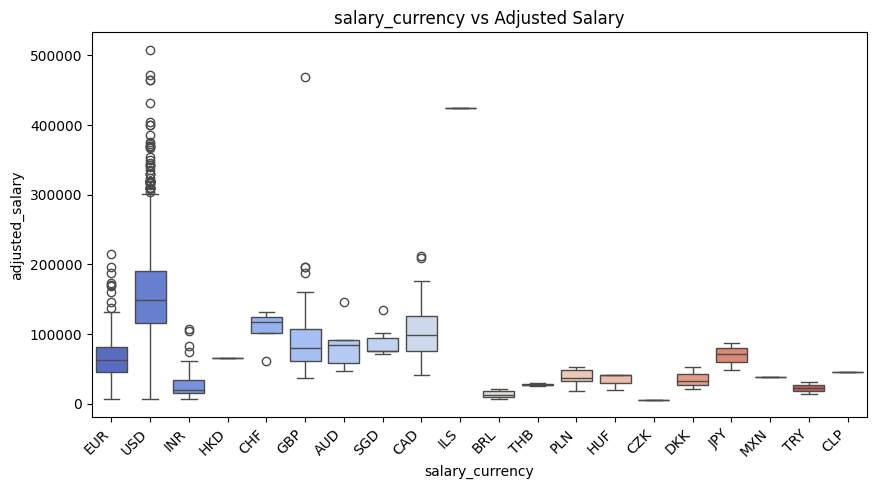

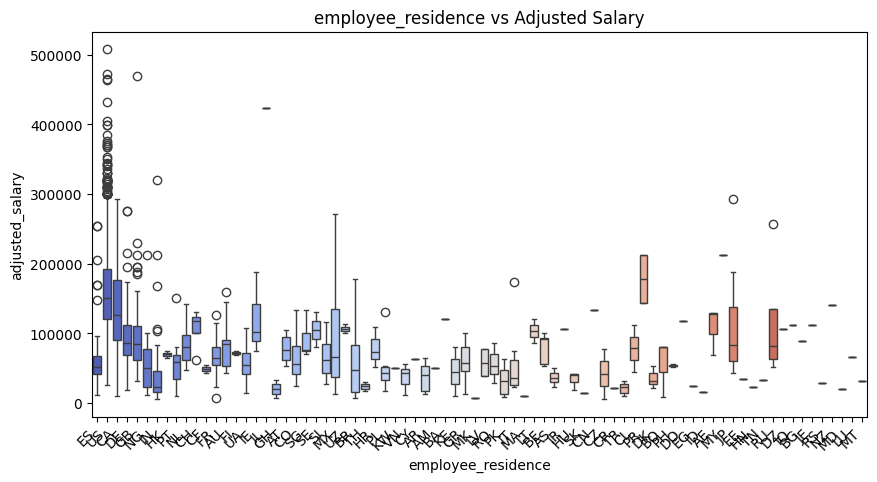

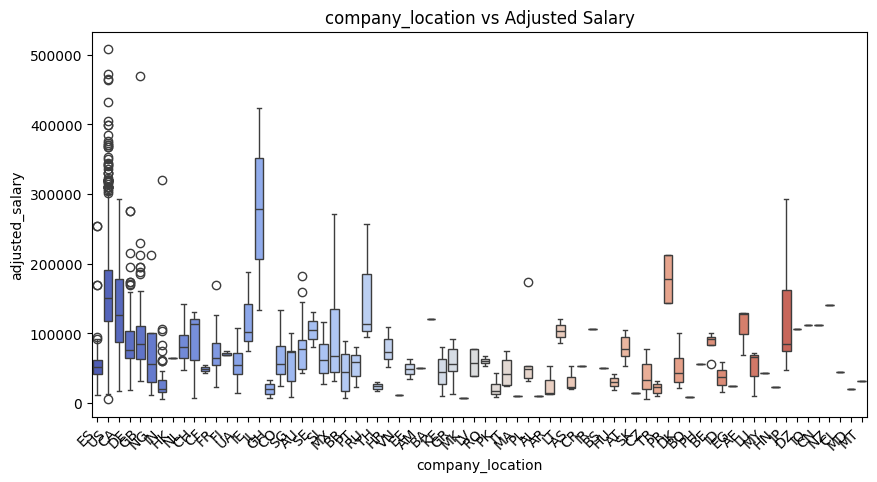

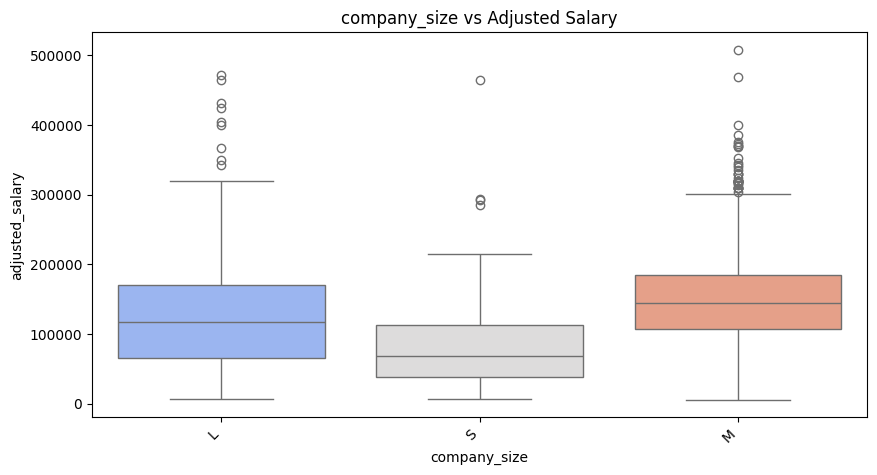

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = "/content/ml_dataset.csv"

# Load the dataset
try:
    processed_df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading the dataset: {e}")
    exit()

# Filter numeric columns
numeric_columns = ['salary', 'salary_in_usd', 'remote_ratio', 'adjusted_salary']

# Calculate the correlation matrix
correlation_matrix = processed_df[numeric_columns].corr()

# 1. Heatmap of the full correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

# 2. Pairplot for numeric columns
sns.pairplot(processed_df[numeric_columns], diag_kind='kde', kind='scatter', corner=True, palette='coolwarm')
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

# 3. Boxplots for categorical variables vs adjusted_salary
categorical_columns = ['work_year', 'experience_level', 'employment_type', 'job_title',
                       'salary_currency', 'employee_residence', 'company_location', 'company_size']

for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=processed_df, x=col, y='adjusted_salary', palette='coolwarm')
    plt.title(f"{col} vs Adjusted Salary")
    plt.xticks(rotation=45, ha='right')
    plt.show()


Data Preparation

In [ ]:
!pip install pycountry==22.3.5 -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#create dictionary of country code to country name mappings
country_map ={}
for country in pycountry.countries:
  country_map[country.alpha_2] = country.name
#replace values in 'employee_residence' column using dictionary
data['employee_residence'] = data['employee_residence'].replace(country_map)
data['company_location'] = data['company_location'].replace(country_map)

In [ ]:
df = data.copy()
df = df.drop(['work_year','salary','salary_currency','salary_in_usd','salary_in_usd',], axis=1)

In [ ]:
categorical_features=['experience_level','employment_type','job_category','employee_residence','company_location','company_size','job_title','remote_ratio'].copy()

In [ ]:
df.head()

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,adjusted_salary
0,SE,FT,Principal Data Scientist,Spain,100,Spain,L,85847.0
1,MI,CT,ML Engineer,United States,100,United States,S,30000.0
2,MI,CT,ML Engineer,United States,100,United States,S,25500.0
3,SE,FT,Data Scientist,Canada,100,Canada,M,175000.0
4,SE,FT,Data Scientist,Canada,100,Canada,M,120000.0


Preprocessing and clustering the data

In [ ]:
print(df.columns)

Index(['experience_level', 'employment_type', 'job_title',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size', 'adjusted_salary'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

df_preprocessed = df.copy()

# Create 'job_category' based on 'job_title'
def map_job_category(title):
    if 'data scientist' in title.lower():
        return 'Data Science'
    elif 'ml engineer' in title.lower() or 'machine learning' in title.lower():
        return 'Machine Learning'
    elif 'engineer' in title.lower():
        return 'Engineering'
    elif 'analyst' in title.lower():
        return 'Analytics'
    else:
        return 'Other'

df_preprocessed['job_category'] = df_preprocessed['job_title'].apply(map_job_category)

# Label encoding for categorical features
le = LabelEncoder()
categorical_features = [
    'experience_level', 'employment_type', 'job_category',
    'employee_residence', 'company_location', 'company_size', 'remote_ratio',
]
for feature in categorical_features:
    df_preprocessed[feature] = le.fit_transform(df_preprocessed[feature])

# MinMax scaling for numerical features
mm = MinMaxScaler()
numerical_features = ['adjusted_salary']
for feature in numerical_features:
    df_preprocessed[feature] = mm.fit_transform(df_preprocessed[feature].values.reshape(-1, 1))


t-SNE Clustering(deetya's)

In [ ]:
#apply t-SNE with different perplexity and learning rate
#tsne=TSNE(n_components = 2,random_state=42,perplexity=50,learning_rate=200)
#tsne_results = tsne.fit_transform(df_preprocessed)

#Plotly Interactive plot

#df_tsne = pd.DataFrame(data = tsne_results,columns  =['Dim_1','Dim_2'])
#df_tsne['adjusted_salary'] = df['adjusted_salary']
#fig=px.scatter(df_tsne, x='Dim_1',y='Dim_2',color='adjusted_salary',title='t-SNE plot colored by Salary')
#fig.show()

t-SNE Clustering(sud's)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify non-numeric columns
non_numeric_columns = df_preprocessed.select_dtypes(include=['object']).columns

# Convert non-numeric columns to numeric using Label Encoding (or one-hot encoding if needed)
for col in non_numeric_columns:
    le = LabelEncoder()
    df_preprocessed[col] = le.fit_transform(df_preprocessed[col])

assert df_preprocessed.select_dtypes(include=['object']).empty, "Non-numeric columns found!"

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
tsne_results = tsne.fit_transform(df_preprocessed)

df_tsne = pd.DataFrame(data=tsne_results, columns=['Dim_1', 'Dim_2'])
df_tsne['adjusted_salary'] = df['adjusted_salary']
fig = px.scatter(df_tsne, x='Dim_1', y='Dim_2', color='adjusted_salary', title='t-SNE plot colored by Salary')
fig.show()


# Salary Prediction

In [ ]:
# Select only numeric columns for outlier detection
numeric_columns = df.select_dtypes(include=['number'])

# Outlier detection using IQR method
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

filtered_df = df[~((numeric_columns < (Q1 - 1.5 * IQR)) | (numeric_columns > (Q3 + 1.5 * IQR))).any(axis=1)]


### Categorize salary to seven ranges

In [ ]:
# Calculate quantiles for salary bin edges
quantiles = [0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1]
bin_edges = [df['adjusted_salary'].quantile(q) for q in quantiles]

# Convert the continuous salary variable into 7 discrete bins based on quantiles
salary_labels = ['low', 'low-mid', 'mid', 'mid-high', 'high', 'very-high', 'Top']
df['salary_range'] = pd.cut(df['adjusted_salary'], bins=bin_edges, labels=salary_labels, include_lowest=True)

## New Method: Using k mean clustering to find the ranges

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Reshape data for clustering
salary_values = df['adjusted_salary'].values.reshape(-1, 1)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=7, random_state=42)
df['salary_cluster'] = kmeans.fit_predict(salary_values)

# Map clusters to labels
cluster_labels = {0: 'low', 1: 'low-mid', 2: 'mid', 3: 'mid-high', 4: 'high', 5: 'very-high', 6: 'Top'}
df['salary_range'] = df['salary_cluster'].map(cluster_labels)


In [ ]:
print("Current Dataset:")
print(df.head())

Current Dataset:
  experience_level employment_type                 job_title  \
0               SE              FT  Principal Data Scientist   
1               MI              CT               ML Engineer   
2               MI              CT               ML Engineer   
3               SE              FT            Data Scientist   
4               SE              FT            Data Scientist   

  employee_residence  remote_ratio company_location company_size  \
0              Spain           100            Spain            L   
1      United States           100    United States            S   
2      United States           100    United States            S   
3             Canada           100           Canada            M   
4             Canada           100           Canada            M   

   adjusted_salary salary_range  salary_cluster  
0          85847.0    very-high               5  
1          30000.0      low-mid               1  
2          25500.0      low-mid        

## Pre Processing

In [ ]:
def job_category(job_title):
    # Define categories and corresponding job titles
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]

    # Map job titles to categories
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

# Apply the function to create a new column 'job_category'
df['job_category'] = df['job_title'].apply(job_category)

# Applying Label Encoding
encoder = LabelEncoder()
categorical_features = ['employment_type', 'job_category', 'experience_level',
                        'employee_residence', 'remote_ratio', 'company_location', 'company_size']

for feature in categorical_features:
    df[feature] = encoder.fit_transform(df[feature])

X = df.drop(["adjusted_salary", "salary_range"], axis=1)
y = df["salary_range"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df.to_csv('model_dataset.csv', index=False)

# Model's Used
*   Logistic Regression

*   Random Forest Classifier


*   Gradient Boosting Classifier
*   AdaBoost Classifier

*   Support Vector Classifier (SVC)
*   Decision Tree Classifier

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['float64', 'int64']).columns),  # Numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Categorical features
    ])

# Define models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier())
]

# Model training, evaluation, and selection
best_model = None
best_score = -np.inf

print("Model performance:")
for name, model in models:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{name} - Accuracy: {accuracy:.2f}")

    # Track the best model
    if accuracy > best_score:
        best_score = accuracy
        best_model = pipeline

# Output the best model and its accuracy
print(f"Best model: {best_model.named_steps['model']} with accuracy: {best_score:.2f}")


Model performance:
Logistic Regression - Accuracy: 0.39
Random Forest - Accuracy: 0.41
Gradient Boosting - Accuracy: 0.41
AdaBoost - Accuracy: 0.37
SVM - Accuracy: 0.42
Decision Tree - Accuracy: 0.39
Best model: SVC() with accuracy: 0.42


## Salary Predictor (Prototype)

In [ ]:
import pandas as pd
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Define job categories and their corresponding job titles
job_categories = {
    "Data Engineering": [
        "Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst",
        "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer",
        "BI Data Engineer", "Power BI Developer"
    ],
    "Data Science": [
        "Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher",
        "Deep Learning Researcher", "AI/Computer Vision Engineer"
    ],
    "Machine Learning": [
        "Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer",
        "Principal Machine Learning Engineer"
    ],
    "Data Architecture": [
        "Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"
    ],
    "Management": [
        "Data Science Manager", "Director of Data Science", "Head of Data Science",
        "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management",
        "Data Analytics Manager"
    ]
}

# Load the dataset from a CSV file (replace with your actual file path)
df = pd.read_csv("/content/model_dataset.csv")  # Replace with your actual dataset path

# Ensure that the necessary columns are present in the dataset
required_columns = ['experience_level', 'job_title', 'salary_range']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Dataset must contain the column: {col}")

# Encode salary range into numerical categories (low, mid, high, very high)
salary_mapping = {
    'low': 0,
    'mid': 1,
    'high': 2,
    'very high': 3
}
df['salary_range'] = df['salary_range'].map(salary_mapping)

# Handle missing values by dropping rows with any NaN values (you can choose to impute instead)
df = df.dropna()  # Drop rows with missing values

# Define the features (X) and target (y) for model training
X = df[['experience_level', 'job_title']]  # Features: experience level and job title
y = df['salary_range']  # Target: salary range

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps: scaling for 'experience_level' and one-hot encoding for 'job_title'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['experience_level']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['job_title'])
    ])

# Initialize the K-Nearest Neighbors regressor with 5 neighbors
model = KNeighborsRegressor(n_neighbors=5)

# Create a pipeline that first preprocesses the data and then fits the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Train the model on the training data
pipeline.fit(X_train, y_train)

# Evaluate the model by making predictions on the test data
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)  # Calculate Mean Absolute Error
print(f"Model MAE: {mae:.2f}")

# Save the trained model to a file so it can be used later for predictions
joblib.dump(pipeline, 'best_salary_predictor.pkl')
print("Model saved as 'best_salary_predictor.pkl'.")

# Function to predict salary based on user input
def predict_salary():
    # Load the saved model from the file
    loaded_model = joblib.load('best_salary_predictor.pkl')

    while True:
        try:
            # Display job categories and let the user select one
            print("\nJob Categories:")
            for i, category in enumerate(job_categories.keys(), start=1):
                print(f"{i}. {category}")

            # Get the user's choice for the job category
            category_choice = int(input("\nEnter the number corresponding to your job category: ")) - 1
            if category_choice < 0 or category_choice >= len(job_categories):
                print("Invalid choice. Please try again.")
                continue

            selected_category = list(job_categories.keys())[category_choice]
            available_jobs = job_categories[selected_category]

            print(f"\nAvailable jobs in {selected_category}:")
            for job in available_jobs:
                print(f"- {job}")

            # Collect user input for experience level and job title
            user_input = {
                'experience_level': int(input("\nEnter your experience level (1, 2, 3, 4): ")),
                'job_title': input("Enter your job title from the above list: ").strip()
            }

            # Validate the job title entered by the user
            if user_input['job_title'] not in available_jobs:
                print(f"Invalid job title for {selected_category}. Please try again.")
                continue

            # Convert user input into a DataFrame to pass to the model
            user_df = pd.DataFrame([user_input])

            # Make the salary prediction based on the user input
            salary_prediction = loaded_model.predict(user_df)

            # Map the predicted numeric salary range back to the original category (low, mid, high, very high)
            reverse_salary_mapping = {v: k for k, v in salary_mapping.items()}
            predicted_category = reverse_salary_mapping[int(round(salary_prediction[0]))]

            print(f"\nPredicted Salary Range: {predicted_category.capitalize()}")
            break  # Exit after successful prediction

        except ValueError:
            print("Invalid input. Please try again.")

# Main loop for user interaction, allowing multiple salary predictions
if __name__ == '__main__':
    print("\nWelcome to the Salary Predictor!")
    while True:
        predict_salary()  # Predict salary based on user input
        cont = input("\nDo you want to predict another salary? (yes/no): ").strip().lower()
        if cont != 'yes':
            print("Goodbye!")  # Exit if the user doesn't want to predict again
            break


Model MAE: 0.82
Model saved as 'best_salary_predictor.pkl'.

Welcome to the Salary Predictor!

Job Categories:
1. Data Engineering
2. Data Science
3. Machine Learning
4. Data Architecture
5. Management

Enter the number corresponding to your job category: 3

Available jobs in Machine Learning:
- Machine Learning Engineer
- ML Engineer
- Lead Machine Learning Engineer
- Principal Machine Learning Engineer

Enter your experience level (1, 2, 3, 4): 2
Enter your job title from the above list: ML engineer
Invalid job title for Machine Learning. Please try again.

Job Categories:
1. Data Engineering
2. Data Science
3. Machine Learning
4. Data Architecture
5. Management

Enter the number corresponding to your job category: 3

Available jobs in Machine Learning:
- Machine Learning Engineer
- ML Engineer
- Lead Machine Learning Engineer
- Principal Machine Learning Engineer

Enter your experience level (1, 2, 3, 4): 2
Enter your job title from the above list: ML Engineer

Predicted Salary Rang

# KNN ALGORITHM TO PREDICT SALARY (PROTOTYPE)

In [ ]:
import pandas as pd
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Define job categories and their corresponding job titles
job_categories = {
    "Data Engineering": [
        "Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst",
        "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer",
        "BI Data Engineer", "Power BI Developer"
    ],
    "Data Science": [
        "Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher",
        "Deep Learning Researcher", "AI/Computer Vision Engineer"
    ],
    "Machine Learning": [
        "Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer",
        "Principal Machine Learning Engineer"
    ],
    "Data Architecture": [
        "Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"
    ],
    "Management": [
        "Data Science Manager", "Director of Data Science", "Head of Data Science",
        "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management",
        "Data Analytics Manager"
    ]
}

# Load dataset
df = pd.read_csv("/content/model_dataset.csv")

# Ensure required columns are present in the dataset
required_columns = ['experience_level', 'job_title', 'salary_range']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Dataset must contain the column: {col}")

# Encode salary range into numerical categories
salary_mapping = {
    'low': 0,
    'mid': 1,
    'high': 2,
    'very high': 3
}
df['salary_range'] = df['salary_range'].map(salary_mapping)

# Handle missing values (drop rows with missing data)
df = df.dropna()

# Define the features and target
X = df[['experience_level', 'job_title']]
y = df['salary_range']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Scale experience_level and one-hot encode job_title
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['experience_level']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['job_title'])
    ])

# Initialize the K-Nearest Neighbors regressor with 5 neighbors
model = KNeighborsRegressor(n_neighbors=5)

# Create a pipeline with preprocessing and the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Train the model on the training data
pipeline.fit(X_train, y_train)

# Evaluate the model using the test set
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Model MAE: {mae:.2f}")

# Save the trained model
joblib.dump(pipeline, 'best_salary_predictor.pkl')
print("Model saved as 'best_salary_predictor.pkl'.")

# Function to predict salary based on user input
def predict_salary():
    # Load the saved model
    loaded_model = joblib.load('best_salary_predictor.pkl')

    while True:
        try:
            # Display job categories and allow user to select one
            print("\nJob Categories:")
            for i, category in enumerate(job_categories.keys(), start=1):
                print(f"{i}. {category}")

            # Get the user's choice for the job category
            category_choice = int(input("\nEnter the number corresponding to your job category: ")) - 1
            if category_choice < 0 or category_choice >= len(job_categories):
                print("Invalid choice. Please try again.")
                continue

            selected_category = list(job_categories.keys())[category_choice]
            available_jobs = job_categories[selected_category]

            print(f"\nAvailable jobs in {selected_category}:")
            for job in available_jobs:
                print(f"- {job}")

            # Collect user input for experience level and job title
            user_input = {
                'experience_level': int(input("\nEnter your experience level (1, 2, 3, 4): ")),
                'job_title': input("Enter your job title from the above list: ").strip()
            }

            # Validate the job title entered by the user
            if user_input['job_title'] not in available_jobs:
                print(f"Invalid job title for {selected_category}. Please try again.")
                continue

            # Convert user input into a DataFrame for prediction
            user_df = pd.DataFrame([user_input])

            # Predict the salary range
            salary_prediction = loaded_model.predict(user_df)

            # Map numeric prediction back to salary range category
            reverse_salary_mapping = {v: k for k, v in salary_mapping.items()}
            predicted_category = reverse_salary_mapping[int(round(salary_prediction[0]))]

            print(f"\nPredicted Salary Range: {predicted_category.capitalize()}")
            break  # Exit after successful prediction

        except ValueError:
            print("Invalid input. Please try again.")

# Main loop to allow multiple salary predictions
if __name__ == '__main__':
    print("\nWelcome to the Salary Predictor!")
    while True:
        predict_salary()
        cont = input("\nDo you want to predict another salary? (yes/no): ").strip().lower()
        if cont != 'yes':
            print("Goodbye!")
            break


Model MAE: 0.82
Model saved as 'best_salary_predictor.pkl'.

Welcome to the Salary Predictor!

Job Categories:
1. Data Engineering
2. Data Science
3. Machine Learning
4. Data Architecture
5. Management

Enter the number corresponding to your job category: 5

Available jobs in Management:
- Data Science Manager
- Director of Data Science
- Head of Data Science
- Data Scientist Lead
- Head of Machine Learning
- Manager Data Management
- Data Analytics Manager

Enter your experience level (1, 2, 3, 4): 4
Enter your job title from the above list: Data Scientist Lead

Predicted Salary Range: Mid

Do you want to predict another salary? (yes/no): no
Goodbye!
